## 美食分類器 1

在本課程中，我們將探索各種分類器，*根據一組食材來預測某種國家美食*。在此過程中，我們將學習一些利用算法進行分類任務的方法。

### [**課前測驗**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **準備工作**

本課程基於我們的[上一課](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb)，在那裡我們：

-   使用關於亞洲和印度所有美味佳餚的數據集，對分類進行了簡單介紹 😋。

-   探索了一些 [dplyr 動詞](https://dplyr.tidyverse.org/) 來準備和清理數據。

-   使用 ggplot2 創建了漂亮的可視化圖表。

-   演示了如何通過使用 [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html) 預處理來處理不平衡數據。

-   演示了如何 `prep` 和 `bake` 我們的 recipe，以確認其按預期運行。

#### **先決條件**

在本課程中，我們需要以下套件來清理、準備和可視化數據：

-   `tidyverse`： [tidyverse](https://www.tidyverse.org/) 是一個[由 R 套件組成的集合](https://www.tidyverse.org/packages)，旨在讓數據科學更快、更簡單、更有趣！

-   `tidymodels`： [tidymodels](https://www.tidymodels.org/) 框架是一個[由多個套件組成的集合](https://www.tidymodels.org/packages/)，用於建模和機器學習。

-   `themis`： [themis 套件](https://themis.tidymodels.org/) 提供了額外的 Recipes 步驟，用於處理不平衡數據。

-   `nnet`： [nnet 套件](https://cran.r-project.org/web/packages/nnet/nnet.pdf) 提供了用於估算具有單個隱藏層的前饋神經網絡以及多項式邏輯回歸模型的函數。

您可以通過以下方式安裝它們：


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

或者，以下腳本會檢查您是否已安裝完成此模組所需的套件，並在缺少時為您安裝。


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. 將數據分成訓練集和測試集

我們將從上一課的一些步驟開始。

### 使用 `dplyr::select()` 去除最常見且容易在不同菜系間引起混淆的食材。

大家都喜歡米飯、大蒜和薑！


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


太好了！現在，我們要將數據分成 70% 用於訓練，30% 用於測試。我們還會在分割數據時應用「分層」技術，以「保持每種菜系在訓練和驗證數據集中的比例」。

[rsample](https://rsample.tidymodels.org/) 是 Tidymodels 中的一個套件，提供了高效的數據分割和重抽樣的基礎設施：


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. 處理不平衡的數據

如你可能已注意到，在原始數據集以及我們的訓練集裡，菜系的數量分佈非常不均。韓國菜的數量*幾乎*是泰國菜的三倍。不平衡的數據通常會對模型的性能產生負面影響。許多模型在觀測數量相等時表現最佳，因此在面對不平衡數據時往往會遇到困難。

處理不平衡數據集主要有兩種方法：

-   為少數類別添加觀測值：`過採樣`，例如使用 SMOTE 演算法，該演算法通過少數類別的最近鄰居合成生成新的樣本。

-   從多數類別中移除觀測值：`欠採樣`

在之前的課程中，我們展示了如何使用 `recipe` 來處理不平衡的數據集。`recipe` 可以被視為一種藍圖，描述了應該對數據集應用哪些步驟以使其準備好進行數據分析。在我們的案例中，我們希望在 `訓練集` 中菜系的數量分佈是均等的。讓我們直接開始吧！


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

您可以當然先確認（使用 prep+bake）這個食譜是否如您所期望地運作——所有標籤為 `559` 的料理觀察值。

由於我們將使用這個食譜作為建模的預處理器，`workflow()` 會幫我們完成所有的準備和烘焙，因此我們不需要手動估算這個食譜。

現在我們準備好訓練模型了 👩‍💻👨‍💻！

## 3. 選擇您的分類器

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>插畫由 @allison_horst 提供</figcaption>


現在我們需要決定要使用哪種演算法來完成這項工作 🤔。

在 Tidymodels 中，[`parsnip package`](https://parsnip.tidymodels.org/index.html) 提供了一個一致的介面，用於在不同的引擎（套件）中處理模型。請參閱 parsnip 的文件來探索[模型類型與引擎](https://www.tidymodels.org/find/parsnip/#models)以及它們對應的[模型參數](https://www.tidymodels.org/find/parsnip/#model-args)。一開始看到這些選擇可能會覺得眼花撩亂。例如，以下方法都包含分類技術：

-   C5.0 規則型分類模型

-   彈性判別模型

-   線性判別模型

-   正則化判別模型

-   邏輯迴歸模型

-   多項式迴歸模型

-   樸素貝葉斯模型

-   支援向量機

-   最近鄰居法

-   決策樹

-   集成方法

-   神經網路

這個清單還可以繼續延伸！

### **該選擇哪個分類器？**

那麼，應該選擇哪個分類器呢？通常，嘗試多種方法並尋找效果良好的結果是一種測試方式。

> AutoML 巧妙地解決了這個問題，通過在雲端運行這些比較，幫助您為數據選擇最佳的演算法。點擊[這裡](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)試試看。

此外，分類器的選擇取決於我們的問題。例如，當結果可以被分類為「多於兩個類別」時，就像我們的情況一樣，您必須使用`多類別分類演算法`，而不是`二元分類`。

### **更好的方法**

比隨意猜測更好的方法是參考這份可下載的[機器學習備忘單](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott)。在這裡，我們發現針對我們的多類別問題，有一些選擇：

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>微軟演算法備忘單的一部分，詳細說明了多類別分類的選項</figcaption>


### **推理**

讓我們看看在現有的限制條件下，可以採取哪些不同的方法來解決問題：

-   **深度神經網絡過於繁重**。考慮到我們的數據集雖然乾淨但規模較小，並且我們是通過筆記本本地訓練模型，深度神經網絡對於這個任務來說過於笨重。

-   **不使用二分類器**。我們不使用二分類器，因此可以排除 one-vs-all 的方法。

-   **決策樹或邏輯回歸可能有效**。決策樹可能有效，或者對於多分類數據，可以使用多項式回歸/多分類邏輯回歸。

-   **多分類提升決策樹解決的是不同的問題**。多分類提升決策樹最適合非參數任務，例如用於構建排名的任務，因此對我們來說並不適用。

此外，通常在嘗試更複雜的機器學習模型（例如集成方法）之前，最好先構建一個最簡單的模型來了解數據的基本情況。因此，在本課中，我們將從一個 `多項式回歸` 模型開始。

> 邏輯回歸是一種用於結果變量為類別型（或名義型）時的技術。對於二元邏輯回歸，結果變量的數量為兩個，而對於多項式邏輯回歸，結果變量的數量超過兩個。請參閱 [進階回歸方法](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) 以獲取更多閱讀資料。

## 4. 訓練並評估多項式邏輯回歸模型

在 Tidymodels 中，`parsnip::multinom_reg()` 定義了一個模型，該模型使用線性預測器來通過多項分佈預測多分類數據。請參閱 `?multinom_reg()` 以了解可以用於擬合此模型的不同方法/引擎。

在這個例子中，我們將通過默認的 [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) 引擎來擬合一個多項式回歸模型。

> 我對 `penalty` 的值是隨機選擇的。其實有更好的方法來選擇這個值，例如通過 `重抽樣` 和 `調參` 模型，我們稍後會討論這些方法。
>
> 如果您想了解更多關於如何調整模型超參數，請參閱 [Tidymodels: 入門指南](https://www.tidymodels.org/start/tuning/)。


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


做得好 🥳！現在我們已經有了一個配方和模型規格，我們需要找到一種方法，將它們整合成一個物件，這個物件首先會對資料進行前處理，然後在前處理後的資料上擬合模型，並且還能支持潛在的後處理活動。在 Tidymodels 中，這個方便的物件被稱為 [`workflow`](https://workflows.tidymodels.org/)，它能輕鬆地保存你的建模組件！這就像我們在 *Python* 中所稱的 *pipelines*。

那麼，讓我們把所有東西打包成一個 workflow 吧！📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


工作流程 👌👌！一個 **`workflow()`** 可以像模型一樣進行擬合。所以，是時候訓練模型了！


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

輸出顯示了模型在訓練過程中學到的係數。

### 評估訓練好的模型

現在是時候透過測試集來評估模型的表現了 📏！我們先從對測試集進行預測開始吧！


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


出色的工作！在Tidymodels中，可以使用 [yardstick](https://yardstick.tidymodels.org/) 評估模型性能——這是一個使用性能指標來衡量模型效果的套件。正如我們在邏輯迴歸課程中所做的那樣，讓我們從計算混淆矩陣開始。


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

當處理多個類別時，通常更直觀的方式是將其視為熱圖，如下所示：


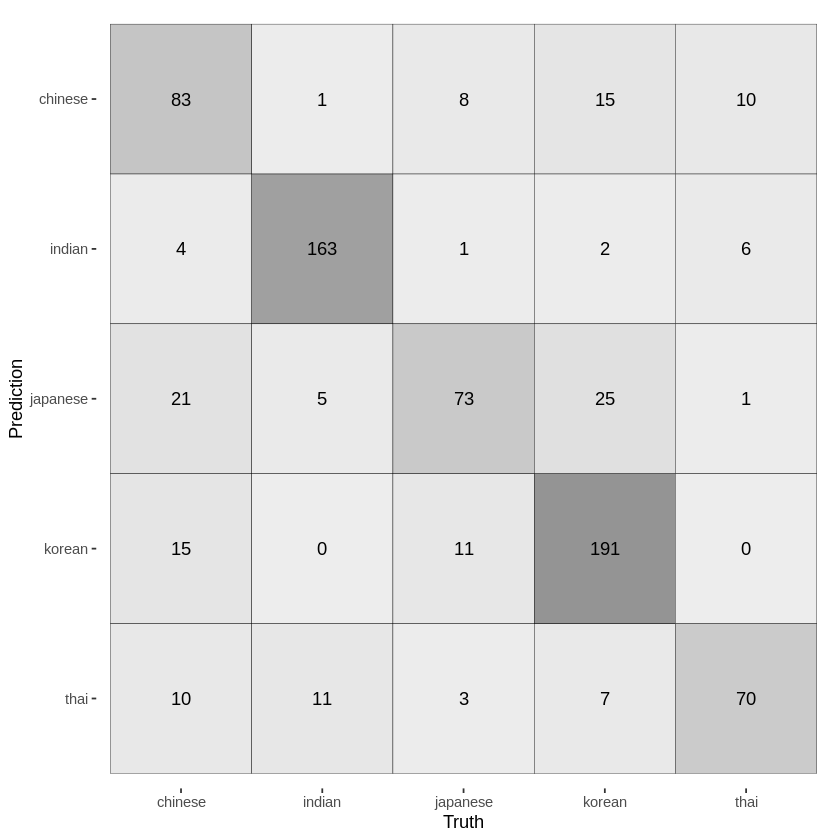

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

混淆矩陣圖中較深的方格表示案例數量較多，您應該可以看到一條由較深方格組成的對角線，表示預測標籤與實際標籤相同的案例。

現在讓我們計算混淆矩陣的摘要統計數據。


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


如果我們聚焦於一些指標，例如準確率、敏感度、ppv，作為起步我們的表現還不算太差 🥳！

## 4. 更深入探討

讓我們來問一個微妙的問題：是什麼標準決定了某種料理類型作為預測結果？

其實，統計機器學習算法，例如邏輯迴歸，是基於`概率`的；因此分類器實際上預測的是一組可能結果的概率分佈。具有最高概率的類別會被選為給定觀測值的最可能結果。

讓我們通過進行硬分類預測和概率預測來看看這是如何運作的。


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


為什麼模型能夠相當確定第一個觀察值是泰國菜？

## **🚀挑戰**

在這節課中，你使用清理過的數據建立了一個機器學習模型，能夠根據一系列食材預測國家料理。花點時間閱讀 [Tidymodels 提供的多種選項](https://www.tidymodels.org/find/parsnip/#models) 來分類數據，以及 [其他方法](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) 來適配多項式回歸。

#### 特別感謝：

[`Allison Horst`](https://twitter.com/allison_horst/) 創作了這些令人驚嘆的插圖，讓 R 語言更加親切且有趣。可以在她的 [畫廊](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM) 中找到更多插圖。

[Cassie Breviu](https://www.twitter.com/cassieview) 和 [Jen Looper](https://www.twitter.com/jenlooper) 創建了這個模組的原始 Python 版本 ♥️

<br>
本來想加點笑話，但我對食物的雙關語一點都不懂 😅。

<br>

祝學習愉快，

[Eric](https://twitter.com/ericntay)，Gold Microsoft Learn 學生大使



---

**免責聲明**：  
本文件已使用 AI 翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。儘管我們努力確保翻譯的準確性，但請注意，自動翻譯可能包含錯誤或不準確之處。原始文件的母語版本應被視為權威來源。對於關鍵資訊，建議使用專業人工翻譯。我們對因使用此翻譯而引起的任何誤解或誤釋不承擔責任。
